## Анализ и подготовка данных 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


### data_arc

In [2]:
try:
    data_arc = pd.read_csv('arc_new.csv')
except:
    print('unable to open the file arc')

In [3]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc['Реактивная мощность'].describe()

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

Итак, приведу в порядок таблицу data_arc. Заменю названия столбцов

In [4]:
col_arc = {'Начало нагрева дугой':'arc_start_heat', 'Конец нагрева дугой':'arc_finish_heat', 'Активная мощность':'activ_p', 'Реактивная мощность':'reactiv_p'}
new_data_arc = data_arc.rename(columns=col_arc)
new_data_arc.head()

,key,arc_start_heat,arc_finish_heat,activ_p,reactiv_p
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Теперь найду полную мощность и добавлю её в новую таблицу. Полная мощность S - это корень из суммы квадратов активной и реактивной мощностей. Посчитаю и организую новый столбец 'total_p'

In [5]:
new_data_arc['total_p'] = (new_data_arc['activ_p']**2 + new_data_arc['reactiv_p']**2)**0.5
new_data_arc.head()

,key,arc_start_heat,arc_finish_heat,activ_p,reactiv_p,total_p
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Найду полное время нагрева в секундах и создам столбец arc_total_time

In [6]:
new_data_arc['arc_start_heat'] = pd.to_datetime(new_data_arc['arc_start_heat'], format='%Y-%m-%dT%H:%M:%S')
new_data_arc['arc_finish_heat'] = pd.to_datetime(new_data_arc['arc_finish_heat'], format='%Y-%m-%dT%H:%M:%S')
new_data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              14875 non-null  int64         
 1   arc_start_heat   14875 non-null  datetime64[ns]
 2   arc_finish_heat  14875 non-null  datetime64[ns]
 3   activ_p          14875 non-null  float64       
 4   reactiv_p        14875 non-null  float64       
 5   total_p          14875 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 813.5 KB


In [7]:
new_data_arc['arc_total_time'] = (new_data_arc['arc_finish_heat'] - new_data_arc['arc_start_heat']).dt.seconds
new_data_arc.head()

,key,arc_start_heat,arc_finish_heat,activ_p,reactiv_p,total_p,arc_total_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148


Посчитаю количество итераций нагрева

In [8]:
count_heat = data_arc['key'].value_counts().reset_index(name='count_heat').rename(columns={'index':'key'})
count_heat

,key,count_heat
0,2108,16
1,1689,15
2,1513,15
3,2567,14
4,46,13
...,...,...
3209,247,1
3210,2582,1
3211,943,1
3212,248,1


Теперь просуммирую все значения по 'key'

In [9]:
new_data_arc = new_data_arc.groupby(by='key').sum()
new_data_arc = new_data_arc.merge(count_heat, on='key')
new_data_arc.head()

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat
0,1,3.036730,2.142821,3.718736,1098,5
1,2,2.139408,1.453357,2.588349,811,4
2,3,4.063641,2.937457,5.019223,655,5
3,4,2.706489,2.056992,3.400038,741,4
4,5,2.252950,1.687991,2.816980,869,4


### data_bulk

In [10]:
try:
    data_bulk_v = pd.read_csv('bulk_new.csv')
except:
    print('unable to open the file bulk')

Теперь в таблице с сыпучими присадками оставлю только те столбцы, в которых заполнено больше половины ячеек

In [11]:
new_data_bulk = data_bulk_v[['key', 'Bulk 12', 'Bulk 14', 'Bulk 15']]

Приведу в порядок названия столбцов

In [12]:
colu_b = {'Bulk 12':'bulk_12', 'Bulk 14':'bulk_14', 'Bulk 15':'bulk_15'}
new_data_bulk = new_data_bulk.rename(columns=colu_b)
new_data_bulk.head()

,key,bulk_12,bulk_14,bulk_15
0,1,206.0,150.0,154.0
1,2,206.0,149.0,154.0
2,3,205.0,152.0,153.0
3,4,207.0,153.0,154.0
4,5,203.0,151.0,152.0


Заменю пропуски нулями, а тип данных int-ом

In [13]:
new_data_bulk = new_data_bulk.fillna(0)

In [14]:
new_data_bulk = new_data_bulk.astype('int32')
new_data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int32
 1   bulk_12  3129 non-null   int32
 2   bulk_14  3129 non-null   int32
 3   bulk_15  3129 non-null   int32
dtypes: int32(4)
memory usage: 49.0 KB


### data_gas

In [15]:
try:
    data_gas = pd.read_csv('gas_new.csv')
except:
    print('unable to open the file gas')

в таблице с инертным газом подправлю название столбца

In [16]:
col_g = {'Газ 1': 'gas_1'}
new_data_gas = data_gas.rename(columns=col_g)
new_data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### data_temp

In [17]:
try:
    data_temp = pd.read_csv('temp_new.csv')
except:
    print('unable to open the file temp')

уберу данные, где температура нагрева ниже 1490 гр.

In [18]:
data_temp = data_temp.query('Температура > 1490')

в таблице data_temp нужно заменить названия столбцов

In [19]:
col_t = {'Время замера':'time_temp', 'Температура':'temp'}
data_temp = data_temp.rename(columns=col_t)
data_temp.head()

,key,time_temp,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Думаю, не смотря на большое количество пропусков, их всё же нужно удалить

In [20]:
data_temp = data_temp.dropna().reset_index(drop=True)
data_temp=data_temp.sort_values(by='time_temp')

Тип данных температуры можно перевести в int

In [21]:
data_temp['temp'] = data_temp['temp'].astype('int32')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 14659
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   key        14660 non-null  int64 
 1   time_temp  14660 non-null  object
 2   temp       14660 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 400.9+ KB


готово

Посмотрю сколько замеряли температуру для каждой key.

In [22]:
times_measur = data_temp['key'].value_counts().reset_index(name='times_measur').rename(columns={'index':'key'})
times_measur.tail()

,key,times_measur
3210,3236,1
3211,2963,1
3212,2955,1
3213,2947,1
3214,2525,1


есть строки с одним замером температуры

In [23]:
times_measur.query('times_measur < 2').sort_values(by='key', ascending=True).head(100)

,key,times_measur
2821,195,1
2629,279,1
2829,2500,1
2865,2501,1
2689,2502,1
...,...,...
2806,2594,1
3003,2595,1
2778,2596,1
2854,2597,1


начиная с партии 2500 количество замеров равно единице. Придётся убрать партии, начиная с 2500, так как первое измерение будет равно последнему. Кроме того, необходимо добавить в новую таблицу значения разницы конечной и начальной температур.

In [24]:
new_data_temp = data_temp.groupby(by='key').agg(['first', 'last']).reset_index()
new_data_temp.columns = ['key', 'start_t_ts', 'finish_t_ts', 'start_t', 'finish_t']
new_data_temp['start_t_ts'] = pd.to_datetime(new_data_temp['start_t_ts'], format='%Y-%m-%dT%H:%M:%S')
new_data_temp['finish_t_ts'] = pd.to_datetime(new_data_temp['finish_t_ts'], format='%Y-%m-%dT%H:%M:%S')
new_data_temp['diffr_temp_time'] = (new_data_temp['finish_t_ts'] - new_data_temp['start_t_ts']).dt.seconds
new_data_temp.head()

,key,start_t_ts,finish_t_ts,start_t,finish_t,diffr_temp_time
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571,1613,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581,1602,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596,1599,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601,1625,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576,1602,1536


Думаю, нам больше не нужны столбцы start_t_ts и finish_t_ts. Я их убираю

In [25]:
del_col = ['start_t_ts', 'finish_t_ts']
new_data_temp = new_data_temp.drop(columns=del_col)
new_data_temp.head()

,key,start_t,finish_t,diffr_temp_time
0,1,1571,1613,1714
1,2,1581,1602,1265
2,3,1596,1599,1753
3,4,1601,1625,1220
4,5,1576,1602,1536


In [26]:
new_data_temp = new_data_temp.query('key < 2500')
new_data_temp.tail()

,key,start_t,finish_t,diffr_temp_time
2472,2495,1570,1591,1380
2473,2496,1554,1591,1705
2474,2497,1571,1589,962
2475,2498,1591,1594,1520
2476,2499,1569,1603,1537


### data_wire

In [27]:
try:
    data_wire_v = pd.read_csv('/datasets/data_wire_new.csv')
except:
    print('unable to open the file wire') 

Для конечной таблицы с проволокой оставлю только первый столбец, как единственный, в котором заполненность больше половины

In [28]:
new_data_wire_v = data_wire_v[['key', 'Wire 1']]
col_w = {'key':'key', 'Wire 1':'wire_1'}
new_data_wire_v = new_data_wire_v.rename(columns=col_w)
new_data_wire_v.head()

,key,wire_1
0,1,60.059998
1,2,96.052315
2,3,91.160157
3,4,89.063515
4,5,89.238236


### Группировка финальной таблицы

Создам новую таблицу, группируя по 'key', для того, чтобы скормить её моделям

In [29]:
new_data = new_data_arc.merge(new_data_bulk, on='key', how='left')
new_data.head()

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0


In [30]:
new_data = new_data.merge(new_data_gas, on='key', how='left')
new_data.head()

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15,gas_1
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692


In [31]:
new_data = new_data.merge(new_data_temp, on='key', how='left')
new_data.head()

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15,gas_1,start_t,finish_t,diffr_temp_time
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,1571.0,1613.0,1714.0
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,1581.0,1602.0,1265.0
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,1596.0,1599.0,1753.0
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,1601.0,1625.0,1220.0
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,1576.0,1602.0,1536.0


In [32]:
new_data = new_data.merge(new_data_wire_v, on='key', how='left')
new_data.head()

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15,gas_1,start_t,finish_t,diffr_temp_time,wire_1
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,1571.0,1613.0,1714.0,60.059998
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,1581.0,1602.0,1265.0,96.052315
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,1596.0,1599.0,1753.0,91.160157
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,1601.0,1625.0,1220.0,89.063515
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,1576.0,1602.0,1536.0,89.238236


In [33]:
new_data

,key,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15,gas_1,start_t,finish_t,diffr_temp_time,wire_1
0,1,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,1571.0,1613.0,1714.0,60.059998
1,2,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,1581.0,1602.0,1265.0,96.052315
2,3,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,1596.0,1599.0,1753.0,91.160157
3,4,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,1601.0,1625.0,1220.0,89.063515
4,5,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,1576.0,1602.0,1536.0,89.238236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3237,2.541872,2.025417,3.250657,909,5,252.0,130.0,206.0,5.543905,NaN,NaN,NaN,38.088959
3210,3238,1.374821,1.038103,1.723937,546,3,254.0,108.0,106.0,6.745669,NaN,NaN,NaN,56.128799
3211,3239,4.848005,3.541541,6.014480,1216,8,158.0,270.0,88.0,16.023518,NaN,NaN,NaN,143.357761
3212,3240,3.317679,2.373552,4.082920,839,5,0.0,192.0,54.0,11.863103,NaN,NaN,NaN,34.070400


Столбец key сделал своё дело и может уходить

In [34]:
new_data = new_data.drop('key', axis=1)

In [35]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   activ_p          3214 non-null   float64
 1   reactiv_p        3214 non-null   float64
 2   total_p          3214 non-null   float64
 3   arc_total_time   3214 non-null   int64  
 4   count_heat       3214 non-null   int64  
 5   bulk_12          3128 non-null   float64
 6   bulk_14          3128 non-null   float64
 7   bulk_15          3128 non-null   float64
 8   gas_1            3212 non-null   float64
 9   start_t          2475 non-null   float64
 10  finish_t         2475 non-null   float64
 11  diffr_temp_time  2475 non-null   float64
 12  wire_1           3054 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 351.5 KB


Уберу пропуски

In [36]:
new_data = new_data.dropna()
new_data.isna().sum()

activ_p            0
reactiv_p          0
total_p            0
arc_total_time     0
count_heat         0
bulk_12            0
bulk_14            0
bulk_15            0
gas_1              0
start_t            0
finish_t           0
diffr_temp_time    0
wire_1             0
dtype: int64

In [37]:
new_data

,activ_p,reactiv_p,total_p,arc_total_time,count_heat,bulk_12,bulk_14,bulk_15,gas_1,start_t,finish_t,diffr_temp_time,wire_1
0,3.036730,2.142821,3.718736,1098,5,206.0,150.0,154.0,29.749986,1571.0,1613.0,1714.0,60.059998
1,2.139408,1.453357,2.588349,811,4,206.0,149.0,154.0,12.555561,1581.0,1602.0,1265.0,96.052315
2,4.063641,2.937457,5.019223,655,5,205.0,152.0,153.0,28.554793,1596.0,1599.0,1753.0,91.160157
3,2.706489,2.056992,3.400038,741,4,207.0,153.0,154.0,18.841219,1601.0,1625.0,1220.0,89.063515
4,2.252950,1.687991,2.816980,869,4,203.0,151.0,152.0,5.413692,1576.0,1602.0,1536.0,89.238236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,3.168133,2.210936,3.868721,723,4,256.0,129.0,223.0,7.125735,1570.0,1591.0,1380.0,89.150879
2471,4.174918,2.872031,5.070316,940,6,256.0,129.0,226.0,9.412616,1554.0,1591.0,1705.0,114.179527
2472,3.605239,2.452092,4.360918,569,3,230.0,124.0,226.0,6.271699,1571.0,1589.0,962.0,94.086723
2473,3.202310,2.239820,3.909917,750,5,206.0,129.0,207.0,14.953657,1591.0,1594.0,1520.0,118.110717


### анализ корреляции и удаление избыточных данных

После удаления пропусков проанализирую корреляцию

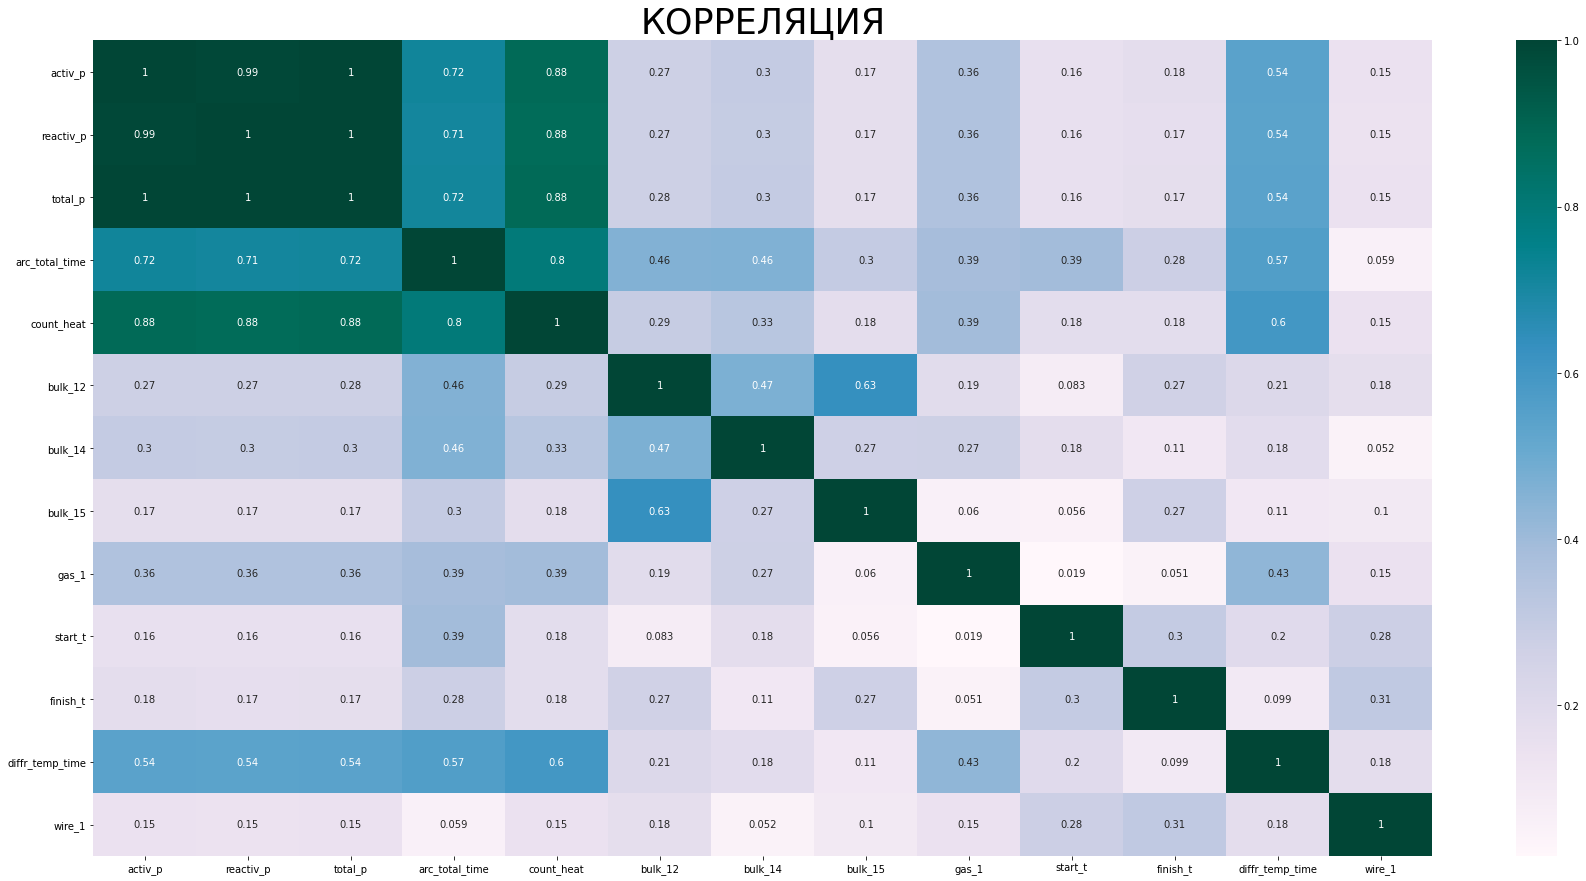

In [38]:
plt.figure(figsize=(30, 15))
fig=sns.heatmap(new_data.corr().abs(), annot=True, cmap='PuBuGn')
plt.title('КОРРЕЛЯЦИЯ', fontsize = 35)
plt.show()

Получили высокую корреляцию между активной, реактивной и полной мощностью, а также временем нагрева дугой и количеством итерраций. Всё логично. Уберу активную, реактивную мощности и количество итерраций.

In [39]:
final_drop = ['activ_p', 'reactiv_p', 'count_heat']
data_for_model = new_data.drop(columns=final_drop)
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2306 entries, 0 to 2474
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_p          2306 non-null   float64
 1   arc_total_time   2306 non-null   int64  
 2   bulk_12          2306 non-null   float64
 3   bulk_14          2306 non-null   float64
 4   bulk_15          2306 non-null   float64
 5   gas_1            2306 non-null   float64
 6   start_t          2306 non-null   float64
 7   finish_t         2306 non-null   float64
 8   diffr_temp_time  2306 non-null   float64
 9   wire_1           2306 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 198.2 KB


## Подготовка target и features

Выделю целевой признак

In [40]:
target = data_for_model['finish_t']
features = data_for_model.drop('finish_t', axis = 1)

В задании указано, что random_state - дата начала проекта

In [41]:
SEED = 280823

Разделю данные на тренировочные и тестовые (25%)

In [42]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state = SEED, shuffle = True)

### Масштабирование признаков

In [43]:
scaler = StandardScaler()
scaler.fit(features_train)
sc_features_train = scaler.transform(features_train)
sc_features_train = pd.DataFrame(sc_features_train, columns=features_train.columns)
sc_features_train.head()

,total_p,arc_total_time,bulk_12,bulk_14,bulk_15,gas_1,start_t,diffr_temp_time,wire_1
0,-0.600391,-0.102617,0.652971,0.660332,0.381094,-0.209410,0.138074,0.902801,-0.196147
1,0.336213,-0.093751,-0.675663,-0.178676,-0.212477,0.894408,-0.755565,-0.700154,-0.509140
2,-0.691080,0.033329,-0.037397,-0.015883,0.381094,-0.702641,-0.244915,-0.513395,-0.599866
3,0.268437,-0.265162,-1.359518,-0.053451,-1.447104,-0.226705,-0.968336,-0.222801,-0.056768
4,-1.348383,0.458901,-0.682175,1.261413,-1.447104,-1.012654,-0.627903,-0.764330,-2.001790


In [44]:
sc_features_test = scaler.transform(features_test)
sc_features_test = pd.DataFrame(sc_features_test, columns=features_test.columns)
sc_features_test.head()

,total_p,arc_total_time,bulk_12,bulk_14,bulk_15,gas_1,start_t,diffr_temp_time,wire_1
0,-0.839962,-0.714377,-1.359518,-1.931827,-1.447104,-0.012483,-0.500240,-0.747745,-1.124035
1,-0.473956,-0.342001,-0.343504,-0.554351,0.998407,-1.248588,-0.372577,-0.647515,-2.144718
2,0.030317,-0.968538,-0.017859,-0.679576,0.998407,-0.290726,0.435953,-0.409560,-0.529991
3,-1.875665,-1.642360,-1.359518,-1.931827,-1.447104,-1.014858,1.925351,-0.837158,-0.414643
4,0.781753,0.990867,1.323801,0.610242,0.998407,2.040652,-1.010891,0.377856,0.408322


## Обучение моделей

### Начнём с линейной регрессии

In [45]:
cv = 5

In [46]:
lr_model = LinearRegression()
lr_score = cross_val_score(lr_model, sc_features_train, target_train, cv=cv, scoring='neg_mean_absolute_error')
mae_lr_score = np.mean(abs(lr_score))
print("linear regression MAE = ", round(mae_lr_score, 1))

linear regression MAE =  6.2


### Cлучайный лес

In [47]:
rfr_model = RandomForestRegressor()
rfr_params = {'max_depth':[10, 20, 30], 'n_estimators':[50, 100, 200], 'min_samples_split':[2, 4, 6], 'random_state':[SEED]}
rfr_grid = GridSearchCV(rfr_model, rfr_params, cv=cv, scoring='neg_mean_absolute_error' )
rfr_grid.fit(features_train, target_train)
rfr_abs_score = abs(rfr_grid.best_score_)
print("random forest regression MAE = ", round(rfr_abs_score, 1))

random forest regression MAE =  6.4


### cat boost

In [57]:
cb_model = CatBoostRegressor(verbose=False)
cb_params = {'depth':[3, 4, 5], 'n_estimators':[200, 500, 800], 'learning_rate':[0.03, 0.1, 0.3], 'random_state':[SEED],
             'loss_function':['MAE']}
cb_grid = GridSearchCV(cb_model, cb_params, cv=cv, scoring='neg_mean_absolute_error')
cb_grid.fit(features_train, target_train)
cb_abs_score = abs(cb_grid.best_score_)
print("cat_boost_regressor MAE = ", round(cb_abs_score, 1))


cat_boost_regressor MAE =  6.0


In [58]:
cb_grid.best_params_

{'depth': 3,
 'learning_rate': 0.1,
 'loss_function': 'MAE',
 'n_estimators': 800,
 'random_state': 280823}

## Опробуем модель на тестовой выборке

Лучшие результаты показал cat boost

In [59]:
model = CatBoostRegressor(depth=3, n_estimators=800, learning_rate=0.1, random_state=SEED, loss_function='MAE', verbose=False)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print("тестовое МАЕ = ", round(mae, 2))

тестовое МАЕ =  5.97


### Анализирую важность факторов

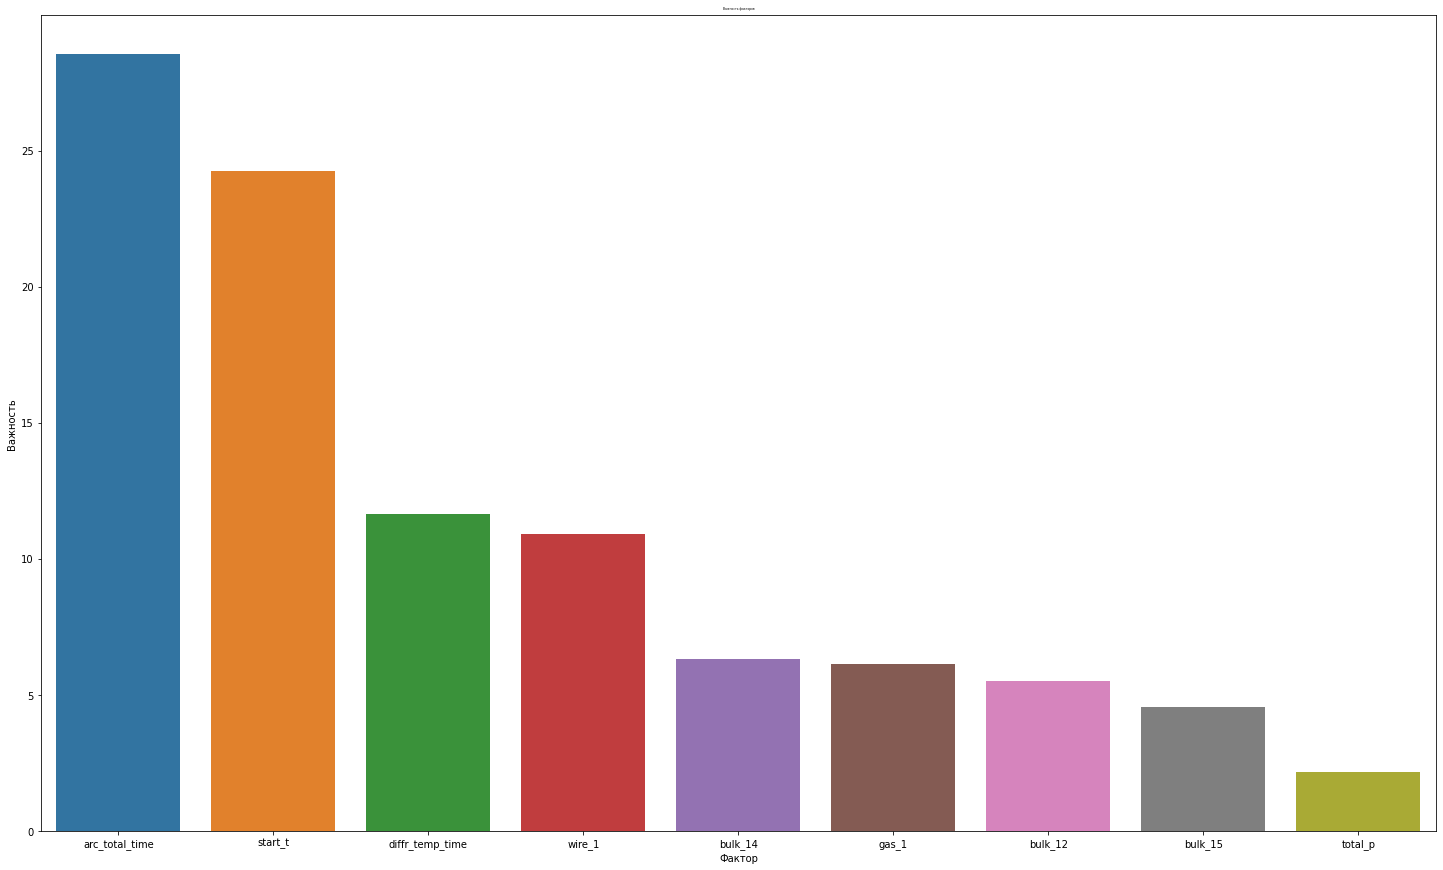

In [51]:
data = {'features': features_test.columns, 'feature_importances':model.feature_importances_}
data = pd.DataFrame(data)
data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.barplot(x=data['features'], y=data['feature_importances'])
plt.title("Важность факторов", fontsize=3)
plt.xlabel('Фактор')
plt.ylabel('Важность')
plt.show()

Получается, что наименее значимым фактором является общая мощность, что мне кажется странным. Но можно попробовать убрать её и посмотреть на результаты.

In [52]:
after_imp_features_train = features_train.copy()
after_imp_features_train = after_imp_features_train.drop('total_p', axis=1)
after_imp_features_test = features_test.copy()
after_imp_features_test = after_imp_features_test.drop('total_p', axis=1)


In [53]:
model.fit(after_imp_features_train, target_train)
predict = model.predict(after_imp_features_test)
after_test_mae =mean_absolute_error(target_test, predict)
print("После удаления общей мощности МАЕ = ", round(after_test_mae, 2))

После удаления общей мощности МАЕ =  5.99


После удаления столбца с общей мощностью значение МАЕ ухудшилось, что лично мне кажется логичным. Оставлю данные такими же, как они были до анализа важности факторов.

***В результате обработки данных***   

__стоблцы были приведены к стандартному виду    
__в таблицу data_arc вычислила и добавила значения полной мощности и полного времени нагрева в секундах, просумировала все значения по key   
__в таблице data_bulk оставила только столбцы с партиями 12, 14, 15, так как в остальных заполнено меньше половины ячеек. Пропуски заполнила нулями.   
__в таблице data_temp удалила все данные, в которых температура ниже 1490 градусов, а также все пропуски. Удалила все значения, в которых только одно измерение температуры     
__в таблице data_wire оставила только один столбец, т.к только в нем были заполнены больше половины ячеек     
__таблицы с временем подачи присадок использовать не стала, так как не считаю, что эти данные каким-либо серьёзным образом могут улучшить качество моделей   
__сформировала новую таблицу, содержащую только необходимую информацию. В таблице удалила пропуски.   
    __проанализировала корреляции и по результатам анализа удалила столбцы с активной, реактивной мощностью и с количеством итерраций    
__данные разделила на features и target, а затем на тренировочные и тестовые в пропорции 3:1    
__обучила модели линейной регрессии, случайного леса и cat boost. Все модели показали допустимые значения на тренировочной выборке   
__лучшее значение получила от cat boost, признала ее победителем     
__провела тестирование на тестовой выборке, получила допустимый результат   
    __провела анализ важности факторов. Самыми влиятельными факторами оказались общее время нагрева электродами и начальная температура.  После анализа важности факторов, попробовала обучить модель без учёта общей мощности, т.к, она показала наименьшую важность. Результат ухудшился. Считаю, что общую мощность необходимо оставить